# Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv

# Download Data

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2021-09-22 11:18:32--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 173.194.217.128, 172.217.193.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2021-09-22 11:18:32 (80.0 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



# Create Time & Series from Data

In [3]:
time_steps = []
sunspots = []

with open('/tmp/sunspots.csv', 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)

  for row in reader:
    sunspots.append(float(row[2]))
    time_steps.append(int(row[0]))

print(time_steps[:10])
print(sunspots[:10])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[96.7, 104.3, 116.7, 92.8, 141.7, 139.2, 158.0, 110.5, 126.5, 125.8]


In [4]:
time = np.array(time_steps)
series = np.array(sunspots)

print(time[:10])
print(series[:10])

[0 1 2 3 4 5 6 7 8 9]
[ 96.7 104.3 116.7  92.8 141.7 139.2 158.  110.5 126.5 125.8]


In [5]:
def plot_time_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

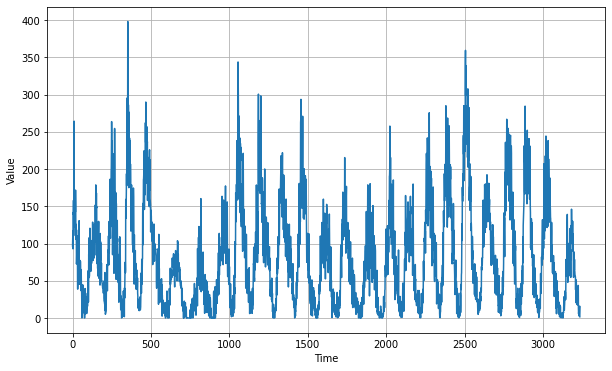

In [6]:
plt.figure(figsize=(10, 6))
plot_time_series(time, series)

# Split Data

In [7]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Windowed Data

In [8]:
window_size = 64
batch_size = 256
shuffle_buffer_size = 1000

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)


# Create & Train the Model

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


In [15]:
history = model.fit(train_set, 
                    epochs=100, 
                    callbacks=[lr_schedule])

Epoch 1/100
12/12 [==============================] - 8s 346ms/step - loss: 342.4054 - mae: 342.9047
Epoch 2/100
12/12 [==============================] - 4s 341ms/step - loss: 313.9037 - mae: 314.4033
Epoch 3/100
12/12 [==============================] - 4s 343ms/step - loss: 281.4919 - mae: 281.9916
Epoch 4/100
12/12 [==============================] - 4s 343ms/step - loss: 252.4561 - mae: 252.9560
Epoch 5/100
12/12 [==============================] - 4s 343ms/step - loss: 224.9270 - mae: 225.4269
Epoch 6/100
12/12 [==============================] - 4s 346ms/step - loss: 186.9040 - mae: 187.4039
Epoch 7/100
12/12 [==============================] - 4s 346ms/step - loss: 148.3062 - mae: 148.8061
Epoch 8/100
12/12 [==============================] - 4s 344ms/step - loss: 137.8564 - mae: 138.3563
Epoch 9/100
12/12 [==============================] - 4s 346ms/step - loss: 131.8696 - mae: 132.3695
Epoch 10/100
12/12 [==============================] - 4s 347ms/step - loss: 126.8958 - mae: 127.3957

# Plot Learning Rate

(1e-08, 0.0001, 0.0, 60.0)

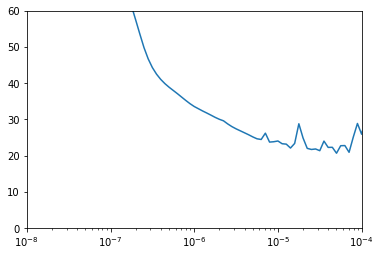

In [16]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

# Create & Train Model with learning rate defined

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 8s 130ms/step - loss: 38.9180 - mae: 39.4144
Epoch 2/500
30/30 [==============================] - 4s 130ms/step - loss: 25.7652 - mae: 26.2597
Epoch 3/500
30/30 [==============================] - 4s 130ms/step - loss: 22.0764 - mae: 22.5701
Epoch 4/500
30/30 [==============================] - 4s 130ms/step - loss: 20.4606 - mae: 20.9535
Epoch 5/500
30/30 [==============================] - 4s 130ms/step - loss: 19.7099 - mae: 20.2024
Epoch 6/500
30/30 [==============================] - 4s 129ms/step - loss: 19.3147 - mae: 19.8068
Epoch 7/500
30/30 [==============================] - 4s 128ms/step - loss: 18.7048 - mae: 19.1970
Epoch 8/500
30/30 [==============================] - 4s 129ms/step - loss: 18.1249 - mae: 18.6166
Epoch 9/500
30/30 [==============================] - 4s 133ms/step - loss: 18.0666 - mae: 18.5581
Epoch 10/500
30/30 [==============================] - 4s 131ms/step - loss: 17.9098 - mae: 18.4011
Epoch 11/500
30/30 

In [18]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)
forecast = forecast[split_time - window_size:-1, -1, 0]

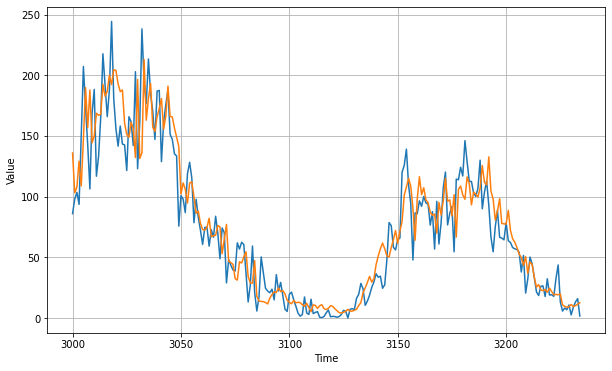

In [20]:
plt.figure(figsize=(10, 6))
plot_time_series(time_valid, x_valid)
plot_time_series(time_valid, forecast)

In [21]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

15.620486

<Figure size 432x288 with 0 Axes>

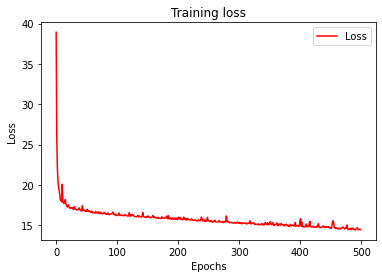

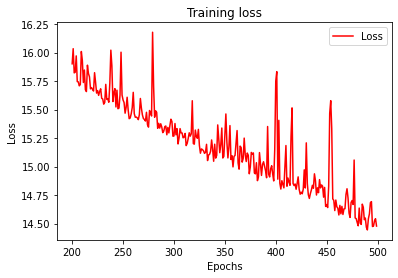

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()